In [17]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.bin.zip
# !unzip wiki-news-300d-1M-subword.bin.zip
# import fasttext
# text_model = fasttext.load_model("wiki-news-300d-1M-subword.bin")
# vector = text_model.get_sentence_vector("This is a long sentence and its vector length = 300")
# vector.shape

# %load_ext autoreload
# %autoreload 2
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.bin.zip
# !unzip wiki-news-300d-1M-subword.bin.zip
# # https://github.com/facebookresearch/fastText/issues/656


(300,)

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath(''))

In [2]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
warnings.filterwarnings('ignore')
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)


from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook
from facebook_hateful_memes_detector.models import LangFeaturesModel
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_basic_image_transforms, TextAugment
from facebook_hateful_memes_detector.training import *



Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
preprocess = get_basic_image_transforms()

choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.2, "char_swap": 0.1, "ocr": 0.1, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.2, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.5, "sentence_shuffle": 0.4, "one_third_cut": 0.5, "half_cut":0.8,
                 "synonym": 0.0,}
preprocess_text = TextAugment([0.05, 0.05, 0.1, 0.3, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")




In [5]:
data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=preprocess, 
                 test_text_transform=None, test_image_transform=preprocess, 
                 cache_images = True, use_images = False, dev=False)


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

## Params

In [6]:
sgd = torch.optim.SGD
sgd_params = dict(lr=5e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=0.001, weight_decay=1e-6)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [12]:
batch_size=512
epochs = 10
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
augmentation_weights = {"None": 1.0}


## LangFeatures GRU

In [13]:
all_caps = ["full_view", "nltk","fasttext_crawl", "spacy", "key_phrases", ] # "snlp", "ibm_max", "tmoji", "key_phrases", "full_view", "spacy", "nltk", "fasttext_crawl"
model_fn = model_builder(LangFeaturesModel, 
                         dict(classifer_dims=256, num_classes=2, 
                              gaussian_noise=0.0, dropout=0.0, embedding_dims=128, internal_dims=512,
                              capabilities=all_caps, classifier="cnn"),
                         optimiser_class=optimizer, optimiser_params=optimizer_params)



n_tests = 1
multi_eval=False
kfold=False

# gaussian_noise=0.9, dropout=0.55, -> adam

# fasttext_crawl 3m 47s 0.710	0.691

# spacy 4m 30s 0.635	0.606

# "key_phrases", "spacy" 7m 9s 0.682	0.660

# "full_view", "nltk" 5m 15s 0.665	0.631

# "snlp" 1h 52m 0.596	0.589

# "fasttext_crawl", "ibm_max", "tmoji" 14m 42s 0.638	0.642

# "gensim" 16m 20s 0.736	0.712


In [14]:

results, prfs = train_validate_ntimes(model_fn, data, n_tests, batch_size, epochs,augmentation_weights, multi_eval=multi_eval, kfold=kfold, scheduler_init_fn=scheduler_init_fn)
r1, p1 = results, prfs
results
prfs


Model Params = 2195056 
 LangFeaturesModel(
  (loss): CrossEntropyLoss()
  (crawl_nn): ExpandContract(
    (nn): Sequential(
      (0): Transpose()
      (1): Dropout(p=0.0, inplace=False)
      (2): Conv1d(600, 384, kernel_size=(1,), stride=(1,), groups=4, bias=False)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Dropout(p=0.0, inplace=False)
      (5): Conv1d(384, 192, kernel_size=(1,), stride=(1,), groups=4, bias=False)
      (6): Transpose()
      (7): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
  )
  (spacy_nn): ExpandContract(
    (nn): Sequential(
      (0): Transpose()
      (1): Dropout(p=0.0, inplace=False)
      (2): Conv1d(282, 256, kernel_size=(1,), stride=(1,), groups=2, bias=False)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Dropout(p=0.0, inplace=False)
      (5): Conv1d(256, 128, kernel_size=(1,), stride=(1,), groups=4, bias=False)
      (6): Transpose()
      (7): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (full_s


Epoch Loss =  1.1822296142578126



Epoch Loss =  0.6917476971944173



Epoch Loss =  0.6866591056187947



Epoch Loss =  0.6865187605222066



Epoch Loss =  0.6731414516766866



Epoch Loss =  0.6623409032821655



Epoch Loss =  0.6637622992197673


Exception for:  keyboard | ! ! | ['half_cut' 'word_join' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch Loss =  0.648258916536967



Epoch Loss =  0.6469460407892863



Epoch Loss =  0.6408494909604391




train   val
mean_or_std metric               
mean        map       0.656 0.601
            accuracy  0.660 0.621
            auc       0.763 0.712
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.829  0.584 0.685 4560.000     0.795  0.540 0.643 1140.000
pos     0.524  0.792 0.631 2640.000     0.489  0.759 0.595  660.000

## Predict



LangFeaturesModel(
  (loss): CrossEntropyLoss()
  (crawl_nn): ExpandContract(
    (nn): Sequential(
      (0): Dropout(p=0.35, inplace=False)
      (1): Linear(in_features=600, out_features=1200, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.35, inplace=False)
      (4): Linear(in_features=1200, out_features=256, bias=True)
      (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (spacy_nn): ExpandContract(
    (nn): Sequential(
      (0): Dropout(p=0.35, inplace=False)
      (1): Linear(in_features=282, out_features=564, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.35, inplace=False)
      (4): Linear(in_features=564, out_features=160, bias=True)
      (5): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
  )
  (key_occ_cnt_pytextrank): Embedding(8, 8)
  (key_wc_pytextrank): Embedding(4, 8)
  (yake_nn): ExpandContract(
    (nn): Sequential(
      (0): Dropout(p=0.35, inplace=False)
      (1):

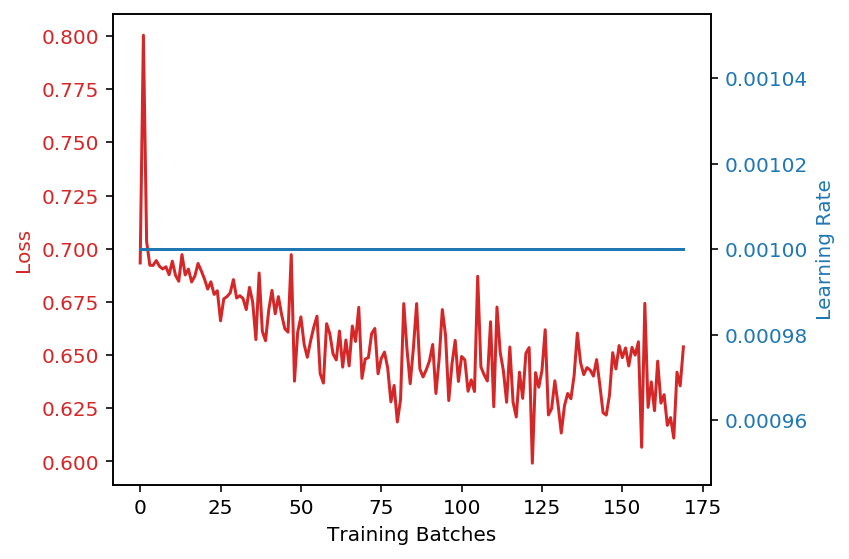

,id,proba,label
0,1284,0.615,1
1,1324,0.383,0
2,1325,0.395,0


In [9]:

submission, model = train_and_predict(model_fn, data, batch_size, epochs, augmentation_weights, scheduler_init_fn=scheduler_init_fn)
submission.to_csv("submission.csv",index=False)
submission.head(3)
